In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bidi-reordered-dataset/bidi_reordered_attacked.csv
/kaggle/input/spellcheck-watermarked/corrected_text.csv
/kaggle/input/watermarked-and-unwatermarked-text-truncated/data_trunk.csv
/kaggle/input/zero-width/attacked_text.csv
/kaggle/input/spelling-mistakes-dataset/mispelled_text.csv


In [2]:
!git clone https://github.com/jthickstun/watermark.git

Cloning into 'watermark'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 80 (delta 25), reused 67 (delta 14), pack-reused 0
Unpacking objects: 100% (80/80), 264.81 KiB | 4.90 MiB/s, done.


In [3]:
import os
os.chdir("/kaggle/working/watermark/demo")

In [4]:
import os, sys, argparse, time

import numpy as np
from transformers import AutoTokenizer
from mersenne import mersenne_rng

import pyximport
pyximport.install(reload_support=True, language_level=sys.version_info[0],
                  setup_args={'include_dirs':np.get_include()})
from levenshtein import levenshtein

def permutation_test(tokens,key,n,k,vocab_size,n_runs=100):
    rng = mersenne_rng(key)
    xi = np.array([rng.rand() for _ in range(n*vocab_size)], dtype=np.float32).reshape(n,vocab_size)
    test_result = detect(tokens,n,k,xi)

    p_val = 0
    for run in range(n_runs):
        xi_alternative = np.random.rand(n, vocab_size).astype(np.float32)
        null_result = detect(tokens,n,k,xi_alternative)

        # assuming lower test values indicate presence of watermark
        p_val += null_result <= test_result

    return (p_val+1.0)/(n_runs+1.0)


def detect(tokens,n,k,xi,gamma=0.0):
    m = len(tokens)
    n = len(xi)

    A = np.empty((m-(k-1),n))
    for i in range(m-(k-1)):
        for j in range(n):
            A[i][j] = levenshtein(tokens[i:i+k],xi[(j+np.arange(k))%n],gamma)

    return np.min(A)


In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.pyxbld/temp.linux-x86_64-cpython-310/kaggle/working/watermark/demo/levenshtein.c:1205:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [5]:
from tqdm import tqdm
import pandas as pd

def main():
    # Read data from CSV using pandas
    data = pd.read_csv("/kaggle/input/spellcheck-watermarked/corrected_text.csv")
    # Combine filtered data
    split_point1 = int(len(data) / 3)
    split_point2 = split_point1 * 2
    split_point3 = 100
    part1 = data.iloc[:100] # First part
    part2 = data.iloc[35:69]  # Second part
    part3 = data.iloc[69:100]  # Third part (might be slightly bigger)
    # Load pre-trained tokenizer (replace with your desired tokenizer)
    tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

    # Progress bar with tqdm
    results = []
    for index, row in tqdm(part1.iterrows(), total=len(part1)):
        text = row["Corrected Text"]  # Assuming "Attacked Text" is the column containing text data
        actual_label = "watermarked" # Assuming "label" is the column containing actual label

        # Tokenize the text
        tokens = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=2048).numpy()[0]

        t0 = time.time()
        pval = permutation_test(tokens, 42, 256, len(tokens), len(tokenizer))
        label = "watermarked" if pval <= 0.01 else "unwatermarked"
        results.append({"text": text, "p-value": pval, "label": label, "actual_label": actual_label})
        print(f"Row {index+1} - p-value: {pval:.4f}, label: {label} (elapsed time: {time.time()-t0:.2f}s)")

    # Create a pandas DataFrame from the results
    df_results = pd.DataFrame(results)
#     df_results.head(2)
    # Save the DataFrame (optional)
    df_results.to_csv("permutation_test_results_spellcheck.csv", index=False)
if __name__ == '__main__':
    main()

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

  1%|          | 1/100 [01:17<2:07:52, 77.50s/it]

Row 1 - p-value: 0.0099, label: watermarked (elapsed time: 77.48s)


  2%|▏         | 2/100 [02:49<2:20:53, 86.26s/it]

Row 2 - p-value: 0.0099, label: watermarked (elapsed time: 92.39s)


  3%|▎         | 3/100 [04:09<2:14:26, 83.16s/it]

Row 3 - p-value: 0.0099, label: watermarked (elapsed time: 79.46s)


  4%|▍         | 4/100 [05:45<2:21:21, 88.35s/it]

Row 4 - p-value: 0.0099, label: watermarked (elapsed time: 96.32s)


  5%|▌         | 5/100 [07:45<2:37:44, 99.63s/it]

Row 5 - p-value: 0.0198, label: unwatermarked (elapsed time: 119.61s)


  6%|▌         | 6/100 [09:12<2:29:29, 95.42s/it]

Row 6 - p-value: 0.0198, label: unwatermarked (elapsed time: 87.26s)


  7%|▋         | 7/100 [10:34<2:21:18, 91.16s/it]

Row 7 - p-value: 0.0297, label: unwatermarked (elapsed time: 82.39s)


  8%|▊         | 8/100 [11:50<2:12:17, 86.28s/it]

Row 8 - p-value: 0.3366, label: unwatermarked (elapsed time: 75.81s)


  9%|▉         | 9/100 [13:16<2:10:44, 86.21s/it]

Row 9 - p-value: 0.6535, label: unwatermarked (elapsed time: 86.06s)


 10%|█         | 10/100 [14:32<2:04:18, 82.88s/it]

Row 10 - p-value: 0.0693, label: unwatermarked (elapsed time: 75.41s)


 11%|█         | 11/100 [16:26<2:17:19, 92.58s/it]

Row 11 - p-value: 0.0099, label: watermarked (elapsed time: 114.59s)


 12%|█▏        | 12/100 [18:00<2:16:05, 92.79s/it]

Row 12 - p-value: 0.0099, label: watermarked (elapsed time: 93.26s)


 13%|█▎        | 13/100 [19:35<2:15:36, 93.52s/it]

Row 13 - p-value: 0.0099, label: watermarked (elapsed time: 95.20s)


 14%|█▍        | 14/100 [20:49<2:05:28, 87.54s/it]

Row 14 - p-value: 0.0099, label: watermarked (elapsed time: 73.72s)


 15%|█▌        | 15/100 [22:25<2:07:53, 90.28s/it]

Row 15 - p-value: 0.0099, label: watermarked (elapsed time: 96.61s)


 16%|█▌        | 16/100 [24:56<2:31:55, 108.52s/it]

Row 16 - p-value: 0.0099, label: watermarked (elapsed time: 150.87s)


 17%|█▋        | 17/100 [26:16<2:18:06, 99.84s/it] 

Row 17 - p-value: 0.0099, label: watermarked (elapsed time: 79.66s)


 18%|█▊        | 18/100 [27:57<2:16:55, 100.19s/it]

Row 18 - p-value: 0.5248, label: unwatermarked (elapsed time: 101.01s)


 19%|█▉        | 19/100 [29:13<2:05:34, 93.02s/it] 

Row 19 - p-value: 0.0099, label: watermarked (elapsed time: 76.30s)


 20%|██        | 20/100 [30:32<1:58:20, 88.76s/it]

Row 20 - p-value: 0.4752, label: unwatermarked (elapsed time: 78.84s)


 21%|██        | 21/100 [32:07<1:59:20, 90.63s/it]

Row 21 - p-value: 0.0693, label: unwatermarked (elapsed time: 94.99s)


 22%|██▏       | 22/100 [34:26<2:16:45, 105.20s/it]

Row 22 - p-value: 0.0099, label: watermarked (elapsed time: 139.16s)


 23%|██▎       | 23/100 [35:48<2:05:53, 98.09s/it] 

Row 23 - p-value: 0.2772, label: unwatermarked (elapsed time: 81.52s)


 24%|██▍       | 24/100 [38:12<2:21:46, 111.93s/it]

Row 24 - p-value: 0.0099, label: watermarked (elapsed time: 144.20s)


 25%|██▌       | 25/100 [39:25<2:05:32, 100.43s/it]

Row 25 - p-value: 0.7525, label: unwatermarked (elapsed time: 73.59s)


 26%|██▌       | 26/100 [41:29<2:12:25, 107.37s/it]

Row 26 - p-value: 0.0099, label: watermarked (elapsed time: 123.56s)


 27%|██▋       | 27/100 [43:21<2:12:24, 108.82s/it]

Row 27 - p-value: 0.0099, label: watermarked (elapsed time: 112.21s)


 28%|██▊       | 28/100 [44:37<1:58:35, 98.82s/it] 

Row 28 - p-value: 0.0099, label: watermarked (elapsed time: 75.49s)


 29%|██▉       | 29/100 [45:48<1:47:14, 90.63s/it]

Row 29 - p-value: 0.0891, label: unwatermarked (elapsed time: 71.52s)


 30%|███       | 30/100 [47:26<1:48:15, 92.80s/it]

Row 30 - p-value: 0.0099, label: watermarked (elapsed time: 97.85s)


 31%|███       | 31/100 [48:44<1:41:31, 88.28s/it]

Row 31 - p-value: 0.0198, label: unwatermarked (elapsed time: 77.74s)


 32%|███▏      | 32/100 [50:39<1:49:05, 96.26s/it]

Row 32 - p-value: 0.0198, label: unwatermarked (elapsed time: 114.88s)


 33%|███▎      | 33/100 [52:04<1:43:54, 93.06s/it]

Row 33 - p-value: 0.0099, label: watermarked (elapsed time: 85.58s)


 34%|███▍      | 34/100 [53:11<1:33:44, 85.22s/it]

Row 34 - p-value: 0.2970, label: unwatermarked (elapsed time: 66.93s)


 35%|███▌      | 35/100 [55:07<1:42:14, 94.38s/it]

Row 35 - p-value: 0.0099, label: watermarked (elapsed time: 115.76s)


 36%|███▌      | 36/100 [57:22<1:53:40, 106.57s/it]

Row 36 - p-value: 0.0099, label: watermarked (elapsed time: 135.01s)


 37%|███▋      | 37/100 [58:41<1:43:14, 98.32s/it] 

Row 37 - p-value: 0.1980, label: unwatermarked (elapsed time: 79.06s)


 38%|███▊      | 38/100 [1:00:32<1:45:32, 102.13s/it]

Row 38 - p-value: 0.0099, label: watermarked (elapsed time: 111.02s)


 39%|███▉      | 39/100 [1:02:33<1:49:39, 107.85s/it]

Row 39 - p-value: 0.0099, label: watermarked (elapsed time: 121.20s)


 40%|████      | 40/100 [1:04:59<1:59:11, 119.19s/it]

Row 40 - p-value: 0.0099, label: watermarked (elapsed time: 145.63s)


 41%|████      | 41/100 [1:06:07<1:42:14, 103.98s/it]

Row 41 - p-value: 0.7030, label: unwatermarked (elapsed time: 68.49s)


 42%|████▏     | 42/100 [1:07:39<1:36:48, 100.15s/it]

Row 42 - p-value: 0.0693, label: unwatermarked (elapsed time: 91.21s)


 43%|████▎     | 43/100 [1:09:05<1:31:08, 95.94s/it] 

Row 43 - p-value: 0.0099, label: watermarked (elapsed time: 86.12s)


 44%|████▍     | 44/100 [1:10:25<1:25:12, 91.30s/it]

Row 44 - p-value: 0.0792, label: unwatermarked (elapsed time: 80.46s)


 45%|████▌     | 45/100 [1:11:35<1:17:52, 84.95s/it]

Row 45 - p-value: 0.0198, label: unwatermarked (elapsed time: 70.15s)


 46%|████▌     | 46/100 [1:13:00<1:16:31, 85.03s/it]

Row 46 - p-value: 0.0495, label: unwatermarked (elapsed time: 85.20s)


 47%|████▋     | 47/100 [1:14:45<1:20:24, 91.02s/it]

Row 47 - p-value: 0.0297, label: unwatermarked (elapsed time: 105.01s)


 48%|████▊     | 48/100 [1:16:49<1:27:22, 100.81s/it]

Row 48 - p-value: 0.0198, label: unwatermarked (elapsed time: 123.65s)


 49%|████▉     | 49/100 [1:18:16<1:22:11, 96.69s/it] 

Row 49 - p-value: 0.0198, label: unwatermarked (elapsed time: 87.08s)


 50%|█████     | 50/100 [1:20:11<1:25:10, 102.21s/it]

Row 50 - p-value: 0.0099, label: watermarked (elapsed time: 115.07s)


 51%|█████     | 51/100 [1:22:31<1:32:42, 113.53s/it]

Row 51 - p-value: 0.0198, label: unwatermarked (elapsed time: 139.93s)


 52%|█████▏    | 52/100 [1:23:52<1:22:52, 103.60s/it]

Row 52 - p-value: 0.0099, label: watermarked (elapsed time: 80.45s)


 53%|█████▎    | 53/100 [1:25:45<1:23:23, 106.46s/it]

Row 53 - p-value: 0.0099, label: watermarked (elapsed time: 113.13s)


 54%|█████▍    | 54/100 [1:27:39<1:23:26, 108.83s/it]

Row 54 - p-value: 0.1881, label: unwatermarked (elapsed time: 114.35s)


 55%|█████▌    | 55/100 [1:28:54<1:14:00, 98.67s/it] 

Row 55 - p-value: 0.0396, label: unwatermarked (elapsed time: 74.97s)


 56%|█████▌    | 56/100 [1:30:21<1:09:50, 95.24s/it]

Row 56 - p-value: 0.0594, label: unwatermarked (elapsed time: 87.23s)


 57%|█████▋    | 57/100 [1:31:50<1:06:54, 93.36s/it]

Row 57 - p-value: 0.5347, label: unwatermarked (elapsed time: 88.99s)


 58%|█████▊    | 58/100 [1:33:29<1:06:25, 94.89s/it]

Row 58 - p-value: 0.0099, label: watermarked (elapsed time: 98.44s)


 59%|█████▉    | 59/100 [1:35:10<1:06:06, 96.73s/it]

Row 59 - p-value: 0.0099, label: watermarked (elapsed time: 101.03s)


 60%|██████    | 60/100 [1:36:39<1:03:01, 94.53s/it]

Row 60 - p-value: 0.0099, label: watermarked (elapsed time: 89.38s)


 61%|██████    | 61/100 [1:38:16<1:01:58, 95.33s/it]

Row 61 - p-value: 0.0099, label: watermarked (elapsed time: 97.21s)


 62%|██████▏   | 62/100 [1:40:16<1:04:53, 102.47s/it]

Row 62 - p-value: 0.0099, label: watermarked (elapsed time: 119.13s)


 63%|██████▎   | 63/100 [1:41:30<57:55, 93.93s/it]   

Row 63 - p-value: 0.8515, label: unwatermarked (elapsed time: 73.98s)


 64%|██████▍   | 64/100 [1:43:25<1:00:11, 100.31s/it]

Row 64 - p-value: 0.0099, label: watermarked (elapsed time: 115.19s)


 65%|██████▌   | 65/100 [1:44:39<53:58, 92.53s/it]   

Row 65 - p-value: 0.0099, label: watermarked (elapsed time: 74.38s)


 66%|██████▌   | 66/100 [1:46:27<54:59, 97.05s/it]

Row 66 - p-value: 0.0099, label: watermarked (elapsed time: 107.61s)


 67%|██████▋   | 67/100 [1:48:06<53:46, 97.77s/it]

Row 67 - p-value: 0.0099, label: watermarked (elapsed time: 99.43s)


 68%|██████▊   | 68/100 [1:49:13<47:15, 88.60s/it]

Row 68 - p-value: 0.0198, label: unwatermarked (elapsed time: 67.19s)


 69%|██████▉   | 69/100 [1:50:39<45:18, 87.70s/it]

Row 69 - p-value: 0.0297, label: unwatermarked (elapsed time: 85.62s)


 70%|███████   | 70/100 [1:52:06<43:45, 87.52s/it]

Row 70 - p-value: 0.0099, label: watermarked (elapsed time: 87.09s)


 71%|███████   | 71/100 [1:53:21<40:31, 83.83s/it]

Row 71 - p-value: 0.0099, label: watermarked (elapsed time: 75.21s)


 72%|███████▏  | 72/100 [1:54:40<38:24, 82.31s/it]

Row 72 - p-value: 0.2970, label: unwatermarked (elapsed time: 78.78s)


 73%|███████▎  | 73/100 [1:56:11<38:15, 85.02s/it]

Row 73 - p-value: 0.0198, label: unwatermarked (elapsed time: 91.35s)


 74%|███████▍  | 74/100 [1:57:38<37:03, 85.52s/it]

Row 74 - p-value: 0.0099, label: watermarked (elapsed time: 86.69s)


 75%|███████▌  | 75/100 [1:59:24<38:09, 91.60s/it]

Row 75 - p-value: 0.0099, label: watermarked (elapsed time: 105.77s)


 76%|███████▌  | 76/100 [2:01:17<39:15, 98.13s/it]

Row 76 - p-value: 0.0099, label: watermarked (elapsed time: 113.38s)


 77%|███████▋  | 77/100 [2:02:28<34:27, 89.89s/it]

Row 77 - p-value: 0.1980, label: unwatermarked (elapsed time: 70.64s)


 78%|███████▊  | 78/100 [2:03:46<31:36, 86.22s/it]

Row 78 - p-value: 0.0099, label: watermarked (elapsed time: 77.68s)


 79%|███████▉  | 79/100 [2:04:59<28:52, 82.52s/it]

Row 79 - p-value: 0.1980, label: unwatermarked (elapsed time: 73.88s)


 80%|████████  | 80/100 [2:06:22<27:30, 82.54s/it]

Row 80 - p-value: 0.1782, label: unwatermarked (elapsed time: 82.57s)


 81%|████████  | 81/100 [2:07:39<25:35, 80.81s/it]

Row 81 - p-value: 0.0099, label: watermarked (elapsed time: 76.79s)


 82%|████████▏ | 82/100 [2:08:47<23:07, 77.06s/it]

Row 82 - p-value: 0.4554, label: unwatermarked (elapsed time: 68.30s)


 83%|████████▎ | 83/100 [2:11:03<26:47, 94.56s/it]

Row 83 - p-value: 0.0099, label: watermarked (elapsed time: 135.39s)


 84%|████████▍ | 84/100 [2:12:17<23:34, 88.43s/it]

Row 84 - p-value: 0.0099, label: watermarked (elapsed time: 74.11s)


 85%|████████▌ | 85/100 [2:13:56<22:57, 91.82s/it]

Row 85 - p-value: 0.0099, label: watermarked (elapsed time: 99.74s)


 86%|████████▌ | 86/100 [2:15:11<20:12, 86.62s/it]

Row 86 - p-value: 0.6832, label: unwatermarked (elapsed time: 74.49s)


 87%|████████▋ | 87/100 [2:16:32<18:23, 84.88s/it]

Row 87 - p-value: 0.0792, label: unwatermarked (elapsed time: 80.82s)


 88%|████████▊ | 88/100 [2:18:33<19:08, 95.70s/it]

Row 88 - p-value: 0.0099, label: watermarked (elapsed time: 120.94s)


 89%|████████▉ | 89/100 [2:19:59<17:02, 92.93s/it]

Row 89 - p-value: 0.1287, label: unwatermarked (elapsed time: 86.46s)


 90%|█████████ | 90/100 [2:21:15<14:39, 87.97s/it]

Row 90 - p-value: 0.0099, label: watermarked (elapsed time: 76.41s)


 91%|█████████ | 91/100 [2:22:25<12:21, 82.38s/it]

Row 91 - p-value: 0.2277, label: unwatermarked (elapsed time: 69.32s)


 92%|█████████▏| 92/100 [2:24:13<12:00, 90.01s/it]

Row 92 - p-value: 0.0198, label: unwatermarked (elapsed time: 107.82s)


 93%|█████████▎| 93/100 [2:25:30<10:03, 86.25s/it]

Row 93 - p-value: 0.0099, label: watermarked (elapsed time: 77.45s)


 94%|█████████▍| 94/100 [2:26:47<08:21, 83.57s/it]

Row 94 - p-value: 0.0099, label: watermarked (elapsed time: 77.34s)


 95%|█████████▌| 95/100 [2:29:07<08:22, 100.52s/it]

Row 95 - p-value: 0.0099, label: watermarked (elapsed time: 140.05s)


 96%|█████████▌| 96/100 [2:30:57<06:52, 103.18s/it]

Row 96 - p-value: 0.0099, label: watermarked (elapsed time: 109.38s)


 97%|█████████▋| 97/100 [2:33:19<05:45, 115.00s/it]

Row 97 - p-value: 0.0099, label: watermarked (elapsed time: 142.58s)


 98%|█████████▊| 98/100 [2:34:38<03:28, 104.16s/it]

Row 98 - p-value: 0.8416, label: unwatermarked (elapsed time: 78.86s)


 99%|█████████▉| 99/100 [2:35:56<01:36, 96.22s/it] 

Row 99 - p-value: 0.5149, label: unwatermarked (elapsed time: 77.70s)


100%|██████████| 100/100 [2:37:10<00:00, 94.30s/it]

Row 100 - p-value: 0.0792, label: unwatermarked (elapsed time: 73.93s)


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


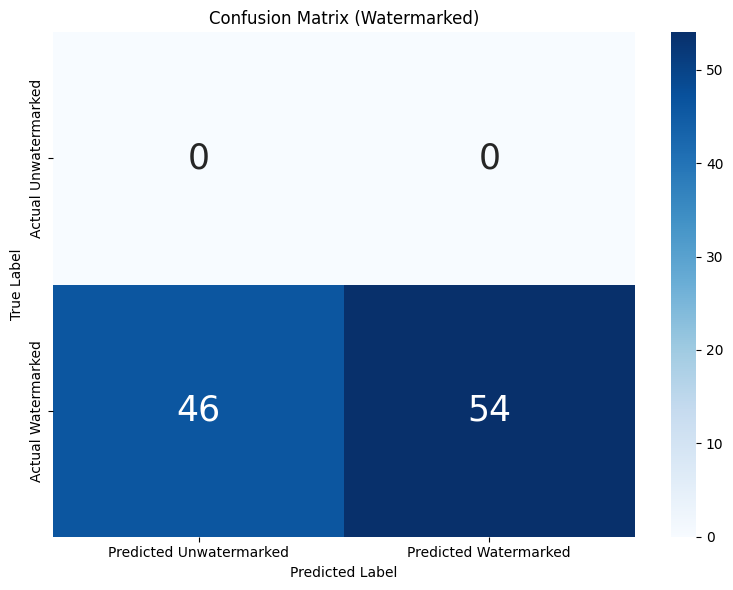


Classification Metrics:
Accuracy: 54.0000
F1-score: 70.1299
Precision: 100.0000
Recall: 54.0000


In [7]:
def evaluate_classification(file_path):

    # Evaluates a classification model using various metrics, reading data from a CSV file and creates a confusion matrix heatmap using seaborn.

    # Read the CSV file assuming 'label' and 'actual_label' columns are present
    df = pd.read_csv(file_path)

    # Extract true labels (assuming 'actual_label' column)
    y_true = df['actual_label'].tolist()

    # Extract predicted labels (assuming 'label' column)
    y_pred = df['label'].tolist()

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate F1-score
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='weighted')
      # Define custom labels for the confusion matrix

    # Create a confusion matrix heatmap using seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',annot_kws={'fontsize': 25})
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix (Watermarked)')
    plt.xticks([0.5, 1.5], ['Predicted Unwatermarked', 'Predicted Watermarked'])
    plt.yticks([0.5, 1.5], ['Actual Unwatermarked', 'Actual Watermarked'])    
    plt.tight_layout()
    plt.show()
    return cm, accuracy, f1, precision, recall

# Specify the file path (assuming you're using Kaggle)
file_path = "/kaggle/working/watermark/demo/permutation_test_results_spellcheck.csv"

# Evaluate the classification
cm, accuracy, f1, precision, recall = evaluate_classification(file_path)

# Print classification metrics (same as before)
print("\nClassification Metrics:")
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"F1-score: {f1 * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")


In [8]:
def evaluate_misclassifications(file_path):
    # Evaluates the average absolute difference between misclassified p-values and the threshold (0.1) for watermarked images.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for misclassified watermarked images
    misclassified_watermarked = df[(df['label'] != df['actual_label']) & (df['actual_label'] == 'watermarked')]

    # Check if there are any misclassified watermarked images
    if len(misclassified_watermarked) == 0:
        print("No misclassified watermarked images found.")
        return None

    # Calculate absolute difference between misclassified p-values and the threshold (0.1)
    abs_diff = np.abs(misclassified_watermarked['p-value'] - 0.1)

    # Calculate average absolute difference
    average_diff = np.mean(abs_diff)

    return average_diff

# Specify the file path
file_path = "/kaggle/working/watermark/demo/permutation_test_results_spellcheck.csv"

# Evaluate misclassifications
average_diff = evaluate_misclassifications(file_path)

if average_diff is not None:
    print(f"Average absolute difference for misclassified watermarked images: {average_diff:.4f}")


Average absolute difference for misclassified watermarked images: 0.1897


In [9]:
def get_incorrect_samples(file_path):
   
    # Extracts all samples from a CSV file where 'label' and 'actual_label' differ.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for rows where label doesn't equal actual_label
    incorrect_samples = df[df['label'] != df['actual_label']]
    incorrect_samples = incorrect_samples.sort_values(by='actual_label')

    return incorrect_samples

file_path = "/kaggle/working/watermark/demo/permutation_test_results_spellcheck.csv"
incorrect_df = get_incorrect_samples(file_path)


incorrect_df.head(len(incorrect_df))

,text,p-value,label,actual_label
4,The government has the power to influence acti...,0.019802,unwatermarked,watermarked
53,You can only find out if you have coronavirus ...,0.188119,unwatermarked,watermarked
54,"The finances should be refunded, but not accom...",0.039604,unwatermarked,watermarked
55,We need more judges to work on the very many p...,0.059406,unwatermarked,watermarked
56,Police are patrolling the area. If there is a ...,0.534653,unwatermarked,watermarked
62,The rigging should be condemned in the communi...,0.851485,unwatermarked,watermarked
67,Always move with your National identity and fo...,0.019802,unwatermarked,watermarked
68,Casava stems are always needed for panting. It...,0.029703,unwatermarked,watermarked
71,Farmers benefit a lot from being part of coope...,0.297030,unwatermarked,watermarked
72,It is unnecessary for one to dress excessively...,0.019802,unwatermarked,watermarked
